In [1]:
import zipfile

with zipfile.ZipFile("/content/Landscape_jpg.zip","r") as zip_ref:
  zip_ref.extractall("/content/Landscapes")


In [2]:
import os
DATA_DIR = '/content/Landscapes'


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

image_size = 256
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=25):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=5).permute(1, 2, 0))

def show_batch(dl, nmax=25):
    for images, _ in dl:
        show_images(images, nmax)
        break

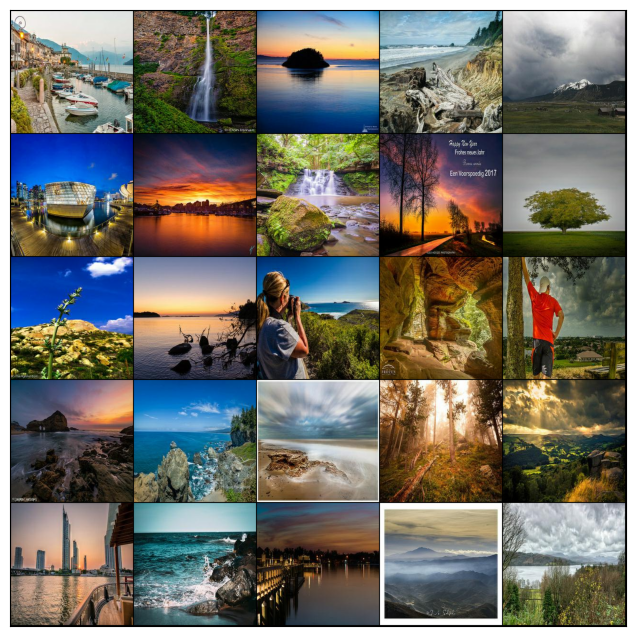

In [7]:
show_batch(train_dl)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
device

device(type='cuda')

In [10]:
import torch.nn as nn  # Building Discriminator Network

discriminator = nn.Sequential(
    # in: 3 x 256 x 256

    nn.Conv2d(3, 90, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(90),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 90 x 128 x 128

    nn.Conv2d(90, 180, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(180),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 180 x 64 x 64

    nn.Conv2d(180, 350, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(350),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 350 x 32 x 32

    nn.Conv2d(350, 470, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(470),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 470 x 16 x 16

    nn.Conv2d(470, 620, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(620),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 620 x 8 x 8

    nn.Conv2d(620, 800, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(800),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 800 x 4 x 4

    nn.Conv2d(800, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [11]:
discriminator = to_device(discriminator, device)

In [19]:
latent_size = 800

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 720, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(720),
    nn.ReLU(True),
    # out: 720 x 4 x 4

    nn.ConvTranspose2d(720, 650, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(650),
    nn.ReLU(True),
    # out: 650 x 8 x 8

    nn.ConvTranspose2d(650, 500, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(500),
    nn.ReLU(True),
    # out: 500 x 16 x 16

    nn.ConvTranspose2d(500, 380, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(380),
    nn.ReLU(True),
    # out: 380 x 32 x 32

    nn.ConvTranspose2d(380, 190, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(190),
    nn.ReLU(True),
    # out: 190 x 64 x 64

    nn.ConvTranspose2d(190, 100, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(100),
    nn.ReLU(True),
    # out: 100 x 128 x 128

    nn.ConvTranspose2d(100, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 256 x 256
)


torch.Size([128, 3, 256, 256])


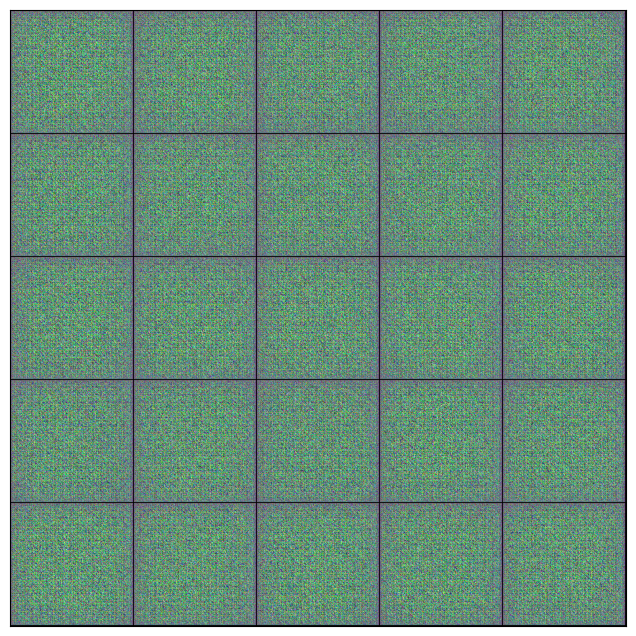

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

In [22]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [30]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=5).permute(1, 2, 0))

In [31]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)


In [32]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [33]:
lr = 0.002
epochs = 50

history = fit(epochs, lr)

  0%|          | 0/20 [00:00<?, ?it/s]

OutOfMemoryError: ignored